In [1]:
import hydra
import rootutils
rootutils.setup_root("../", indicator=".project-root", pythonpath=True)
import os
os.chdir("../")
from src.utils import show_video_line,show_video_gif_multiple,show_video_gif_single
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
# plt.savefig('x.png', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题

In [2]:
from omegaconf import OmegaConf
config = r"./data/data_cloud/config.yaml"
config = OmegaConf.load(config)
config.data.train_config.data_dir="./demo"
config.data.val_config.data_dir="./demo"
config.data.batch_size = 1
config.data.batch_size_val = 1
ckpt = r"./demo/step_4815_loss0.006.ckpt"

A total of 19 image, and has 7 regions; 19 datatimes
only 19 time series is generated wihch has 7 regions ,and 7 time series is valid , length is 19 , information saved in data/temp.json
split_path is not specified, reading from ./demo, got 7 samples
load samples from /home/pandaru/workspace/cloud_forecasting/data//valid.json, got 6 samples
load samples from /home/pandaru/workspace/cloud_forecasting/data//valid.json, got 6 samples
torch.Size([1, 19, 3, 256, 256])


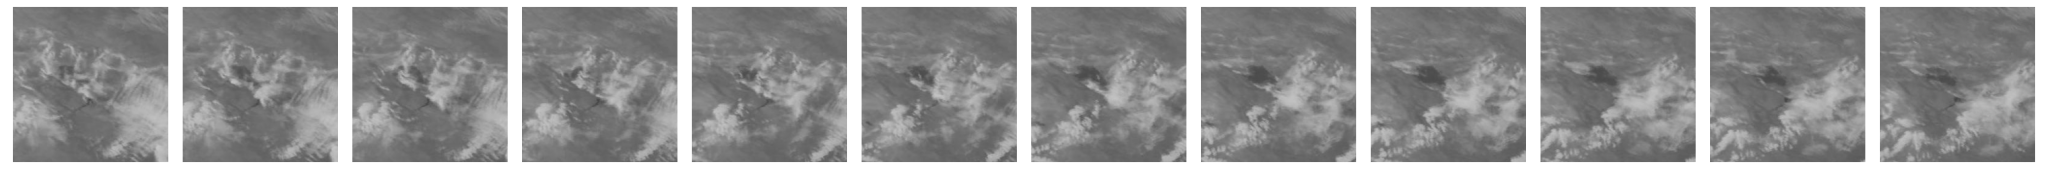

In [3]:
data_module = hydra.utils.instantiate(config.data)
data_module.setup()
batch_sample = next(iter(data_module.val_dataloader()))
print(batch_sample["images"].shape)
show_video_line(batch_sample["images"][0].numpy(), ncols=12, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

In [4]:
import torch
module = hydra.utils.instantiate(config.model)
module.load_state_dict( torch.load(ckpt,map_location="cpu")["state_dict"])
#
print(module.model.configs)#输入前 7帧图像，预测后12帧图像
# mask_true[:, t - self.configs.pre_seq_length] * frames[:, t]
pre_seq_length = module.model.configs.pre_seq_length

{'in_shape': [19, 3, 256, 256], 'patch_size': 2, 'pre_seq_length': 7, 'aft_seq_length': 12, 'total_length': 19, 'filter_size': 5, 'stride': 1, 'layer_norm': 0, 'scheduled_sampling': 1, 'sampling_stop_iter': 13000, 'sampling_start_value': 1.0, 'sampling_changing_rate': 2e-05}


In [5]:
from copy import deepcopy

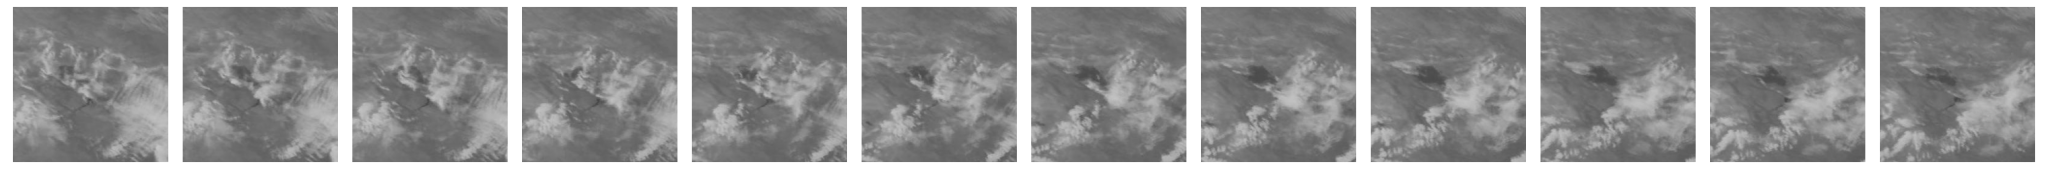

torch.Size([1, 18, 3, 256, 256])


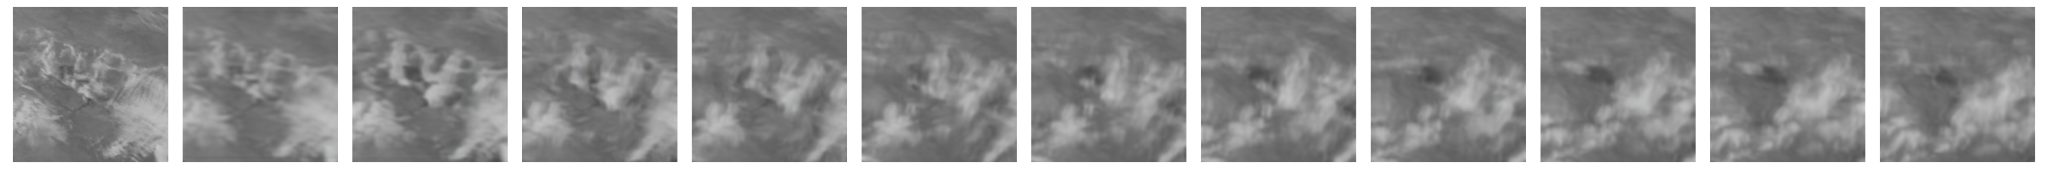

In [10]:
module.model.configs.pre_seq_length = 18 # 使用一张图像来预测未来18张
module.model.configs.aft_seq_length = module.model.configs.total_length - module.model.configs.pre_seq_length
batch_sample_cp = deepcopy(batch_sample)
batch_sample_cp['images'][:,module.model.configs.pre_seq_length:,...] = 0
show_video_line(batch_sample_cp["images"][0].numpy(), ncols=12, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)
with torch.no_grad():
    img_gen, logs  = module.RNN_test_step(batch_sample_cp, "val")
    print(img_gen.shape) # 缺少第一张图
img_gen = torch.concat([batch_sample_cp['images'][:,None,0,...],img_gen],dim=1)
show_video_line(img_gen[0].detach().numpy(), ncols=12, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)
# 预测出输入状态越清晰，准确越能代表RNN学到的时间信息越成功


In [11]:
module.model.configs.pre_seq_length

18

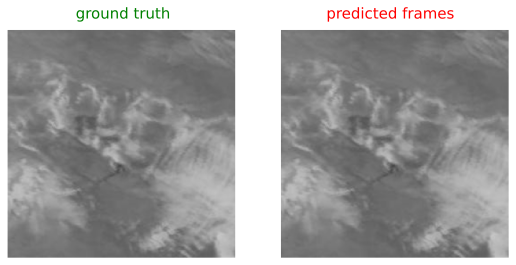

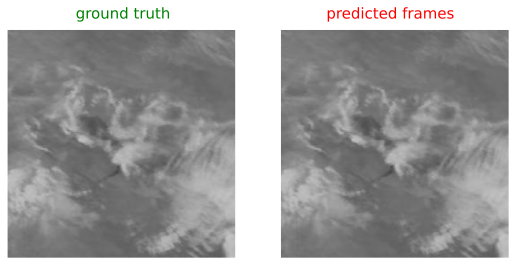

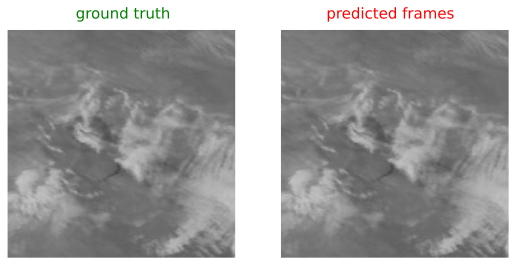

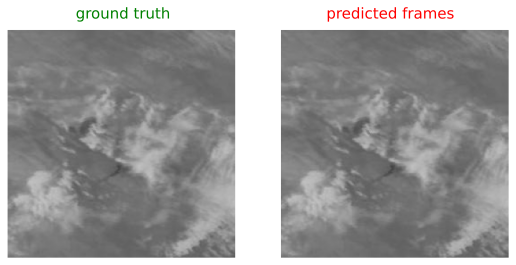

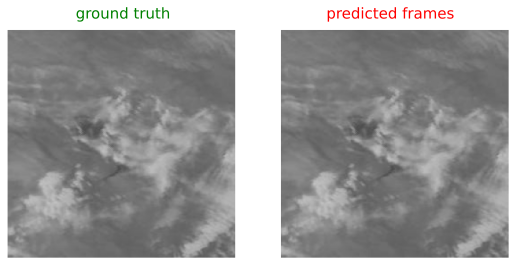

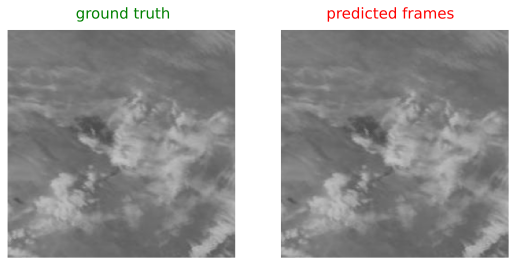

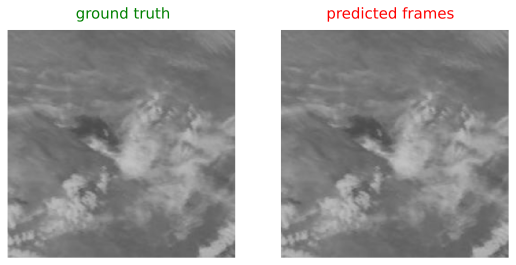

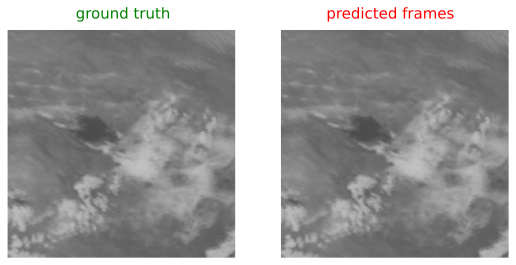

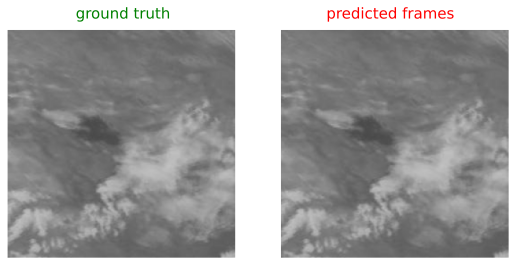

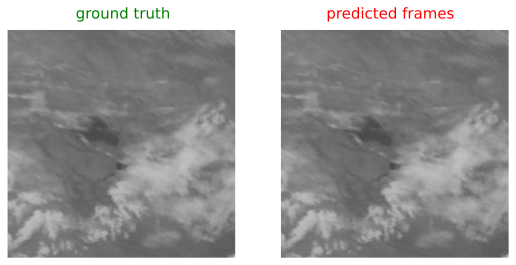

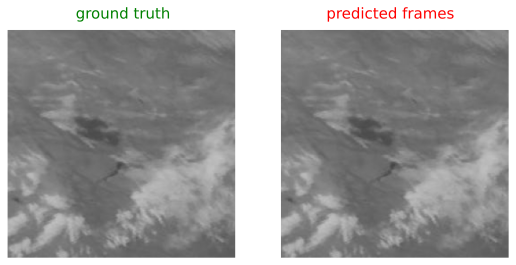

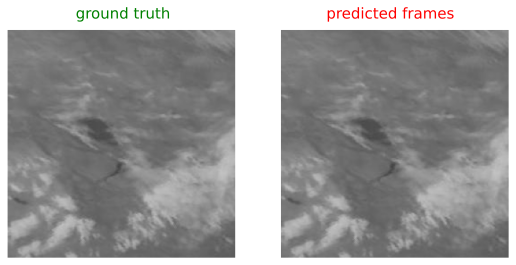

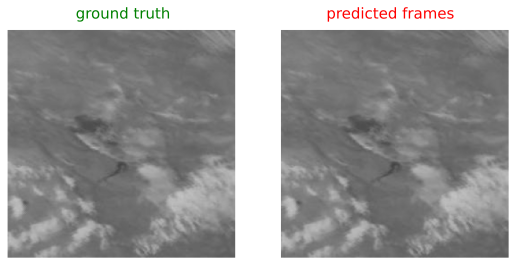

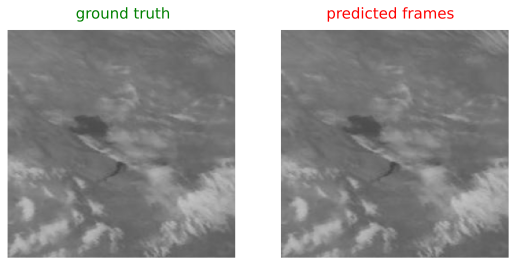

In [12]:
from src.utils import show_video_gif_multiple
# 制作对比gif  -> 用于预测的，待预测的真值，预测结果
# pre_seq_length >= 2
show_video_gif_multiple(batch_sample['images'][:,:module.model.configs.pre_seq_length,...][0], batch_sample['images'][:,module.model.configs.pre_seq_length:,...][0], img_gen.detach().numpy()[0], use_rgb=True, out_path=f'demo/pred/pred_pre_seq-{module.model.configs.pre_seq_length}.gif')

In [ ]:
# # 制作 gif 单个
# show_video_gif_single(
#     img_gen.detach().numpy()[0],
#     out_path=f"data/demo/pred/pred_pre_seq-{module.model.configs.pre_seq_length}.gif"
# )